# Environmental Sound Classification using Deep Learning
## >> Urban sound classification with CNNs


* [0. Load the preprocessed data](#zero-bullet)
* [1. Create a custom dataset class](#first-bullet)
* [2. Data augmentation](#first-bullet)
* [3. CNN model](#third-bullet)
* [4. Helper functions](#fourth-bullet)
* [5. 10-Fold Cross Validation](#fifth-bullet)
* [6. Results](#sixth-bullet)

---

In [1]:
import os
import sys
import pickle
import copy

from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
USE_GOOGLE_COLAB = True

if USE_GOOGLE_COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'/US8K
else:
    %cd US8K

Mounted at /content/gdrive
/content/gdrive/My Drive/US8K


---

## 0. Load the preprocessed data <a name="zero-bullet"></a>

In [ ]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [ ]:
us8k_df.head()

,melspectrogram,label,fold
0,"[[-61.70703, -74.49714, -65.133354, -65.751175...",3,5
1,"[[-11.593532, -3.6112566, -12.501208, -13.6347...",2,5
2,"[[-24.203024, -14.915937, -6.091387, -12.99589...",2,5
3,"[[-15.058913, -12.812816, -12.299819, -11.4387...",2,5
4,"[[-9.8777, 0.0, -11.115205, -10.564414, -3.854...",2,5


---

## 1. Create a custom dataset class  <a name="first-bullet"></a>




In [ ]:
DEFAULT_SAMPLE_RATE = 22050

class UrbanSound8kDataset(Dataset):
    def __init__(self, us8k_df, transform=None):
        assert isinstance(us8k_df, pd.DataFrame)
        assert len(us8k_df.columns) == 3

        self.us8k_df = us8k_df
        self.transform = transform

    def __len__(self):
        return len(self.us8k_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        spectrogram, label, fold = self.us8k_df.iloc[index]

        if self.transform is not None:
            spectrogram = self.transform(spectrogram)

        return {'spectrogram': spectrogram, 'label':label}

---

## 2. Data augmentation


In [ ]:
class MyRightShift(object):
    """Shift the image to the right in time."""

    def __init__(self, input_size, width_shift_range, shift_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(width_shift_range, (int, float))
        assert isinstance(shift_probability, (float))

        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        if isinstance(width_shift_range, int):
            assert width_shift_range > 0
            assert width_shift_range <= self.input_size[1]
            self.width_shift_range = width_shift_range
        else:
            assert width_shift_range > 0.0
            assert width_shift_range <= 1.0
            self.width_shift_range = int(width_shift_range * self.input_size[1])
                        
        assert shift_probability > 0.0 and shift_probability <= 1.0
        self.shift_prob = shift_probability

    def __call__(self, image):
        if np.random.random() > self.shift_prob:
          return image

        # create a new array filled with the min value
        shifted_image= np.full(self.input_size, np.min(image), dtype='float32')

        # randomly choose a start postion
        rand_position = np.random.randint(1, self.width_shift_range)

        # shift the image
        shifted_image[:,rand_position:] = copy.deepcopy(image[:,:-rand_position])

        return shifted_image

class MyAddGaussNoise(object):
    """Add Gaussian noise to the spectrogram image."""

    def __init__(self, input_size, mean=0.0, std=None, add_noise_probability=1.0):
        assert isinstance(input_size, (int, tuple))
        assert isinstance(mean, (int, float))
        assert isinstance(std, (int, float)) or std is None
        assert isinstance(add_noise_probability, (float))


        if isinstance(input_size, int):
            self.input_size = (input_size, input_size)
        else:
            assert len(input_size) == 2
            self.input_size = input_size

        self.mean = mean

        if std is not None:
            assert std > 0.0
            self.std = std
        else:
            self.std = std

        assert add_noise_probability > 0.0 and add_noise_probability <= 1.0
        self.add_noise_prob = add_noise_probability


    def __call__(self, spectrogram):
      if np.random.random() > self.add_noise_prob:
          return spectrogram

      # set some std value 
      min_pixel_value = np.min(spectrogram)
      if self.std is None:
        std_factor = 0.03     # factor number 
        std = np.abs(min_pixel_value*std_factor)

      # generate a white noise spectrogram
      gauss_mask = np.random.normal(self.mean, 
                                    std, 
                                    size=self.input_size).astype('float32')
      
      # add white noise to the sound spectrogram
      noisy_spectrogram = spectrogram + gauss_mask

      return noisy_spectrogram

class MyReshape(object):
    """Reshape the image array."""

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))

        self.output_size = output_size

    def __call__(self, image):
      return image.reshape(self.output_size)

In [ ]:
# build transformation pipelines for data augmentation
train_transforms = transforms.Compose([MyRightShift(input_size=128, 
                                                    width_shift_range=13, 
                                                    shift_probability=0.9),
                                       MyAddGaussNoise(input_size=128,
                                                       add_noise_probability=0.55),
                                       MyReshape(output_size=(1,128,128))])

test_transforms = transforms.Compose([MyReshape(output_size=(1,128,128))])

---

## 3. CNN model  <a name="third-bullet"></a>

In [ ]:
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=0)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=48, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=10)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):
        # cnn layer-1
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=(3,3), stride=3)
        x = F.relu(x)

        # cnn layer-2
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        x = F.relu(x)

        # cnn layer-3
        x = self.conv3(x)
        x = F.relu(x)

        # global average pooling 2D
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(-1, 48)

        # dense layer-1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        # dense output layer
        x = self.fc2(x)

        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def predict(self, X):
        self.eval()
        
        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)
            
            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1) 
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print(net)

cuda:0
Net(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=48, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)


---

## 4. Helper functions  <a name="fourth-bullet"></a>

In [ ]:
def init_model():
    # determine if the system supports CUDA
    if torch.cuda.is_available():
      device = torch.device("cuda:0")
    else:
      device = torch.device("cpu")

    # init model
    net = Net(device).to(device)
  
    return net

In [ ]:
def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_folds = train_df['fold'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels, train_folds), columns=['melspectrogram', 'label', 'fold'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_folds = test_df['fold'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels, test_folds), columns=['melspectrogram', 'label', 'fold'])

    return train_df, test_df

In [ ]:
def process_fold(fold_k, dataset_df, epochs=100, batch_size=32, num_of_workers=0):
    # split the data
    train_df = dataset_df[dataset_df['fold'] != fold_k]
    test_df = dataset_df[dataset_df['fold'] == fold_k]

    # normalize the data
    train_df, test_df = normalize_data(train_df, test_df)

    # init train data loader
    train_ds = UrbanSound8kDataset(train_df, transform=train_transforms)
    train_loader = DataLoader(train_ds, 
                              batch_size=batch_size,
                              shuffle = True,
                              pin_memory=True,
                              num_workers=num_of_workers)
    
    # init test data loader
    test_ds = UrbanSound8kDataset(test_df, transform=test_transforms)
    test_loader = DataLoader(test_ds, 
                            batch_size=batch_size,
                            shuffle = False,
                            pin_memory=True,
                            num_workers=num_of_workers)

    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(test_loader)
    print("Pre-training accuracy: %.4f%%" % (100 * score[1]))
      
    # train the model
    start_time = datetime.now()
    history = model.fit(train_loader, epochs=epochs, val_loader=test_loader)
    end_time = datetime.now() - start_time
    print("\nTraining completed in time: {}".format(end_time))
      
    return history

In [ ]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets."""

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))

        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
            
        plt.show()

        print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history['val_loss']))

---

## 5. 10-Fold Cross Validation  <a name="fifth-bullet"></a>

* [fold-1](#fold-1)
* [fold-2](#fold-2)
* [fold-3](#fold-3)
* [fold-4](#fold-4)
* [fold-5](#fold-5)
* [fold-6](#fold-6)
* [fold-7](#fold-7)
* [fold-8](#fold-8)
* [fold-9](#fold-9)
* [fold-10](#fold-10)

### fold-1 <a name="fold-1"></a>


In [ ]:
FOLD_K = 1
REPEAT = 3

history1 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history1.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 9.1518%

Epoch 1/100
100%|██████████| 246/246 [00:05<00:00, 46.40it/s]
loss: 1.9124 - accuracy: 0.2669 - val_loss: 1.8583 - val_accuracy: 0.2667

Epoch 2/100
100%|██████████| 246/246 [00:05<00:00, 46.78it/s]
loss: 1.8038 - accuracy: 0.2890 - val_loss: 1.7247 - val_accuracy: 0.2868

Epoch 3/100
100%|██████████| 246/246 [00:05<00:00, 44.99it/s]
loss: 1.6888 - accuracy: 0.3592 - val_loss: 1.6140 - val_accuracy: 0.3571

Epoch 4/100
100%|██████████| 246/246 [00:05<00:00, 44.31it/s]
loss: 1.5988 - accuracy: 0.3863 - val_loss: 1.5148 - val_accuracy: 0.3783

Epoch 5/100
100%|██████████| 246/246 [00:05<00:00, 45.22it/s]
loss: 1.4990 - accuracy: 0.4266 - val_loss: 1.4022 - val_accuracy: 0.4062

Epoch 6/100
100%|██████████| 246/246 [00:05<00:00, 45.57it/s]
loss: 1.4648 - accuracy: 0.4299 - val_loss: 1.3813 - val_accuracy: 0.4520

Epoch 7/100
100%|██████████| 246/246 [00:05<00:00, 46.49it/


(1)


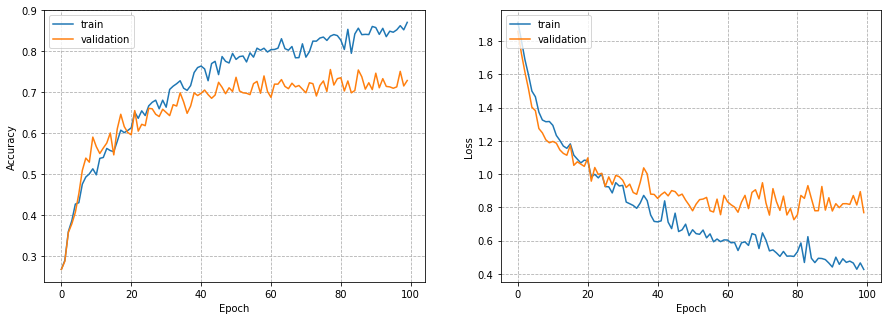

	Max validation accuracy: 75.5580 %
	Min validation loss: 0.72533

(2)


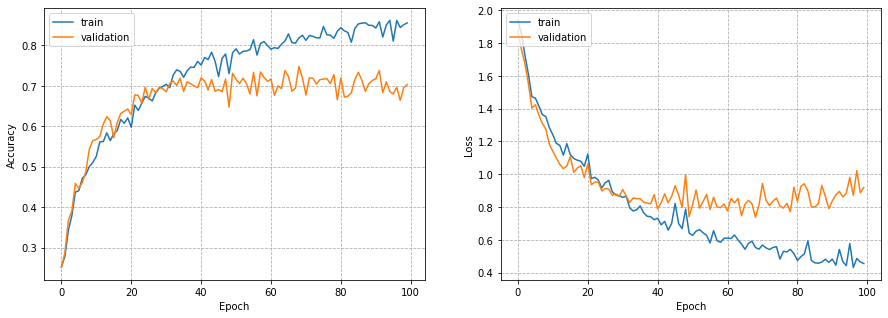

	Max validation accuracy: 74.7768 %
	Min validation loss: 0.73726

(3)


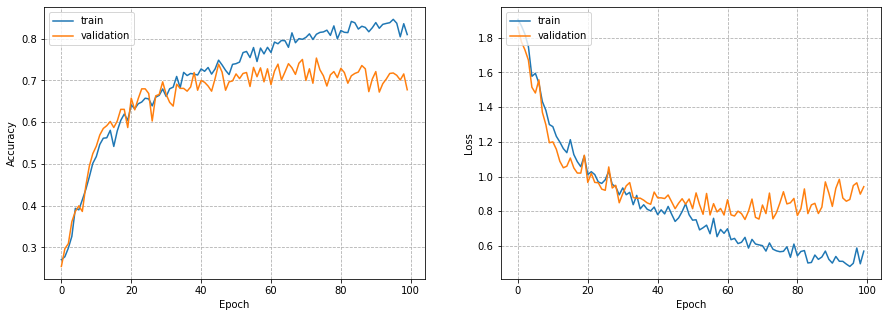

	Max validation accuracy: 75.3348 %
	Min validation loss: 0.75288


In [ ]:
show_results(history1)

In [ ]:
with open("history1", "wb") as fp:   
    pickle.dump(history1, fp)

### fold-2 <a name="fold-2"></a>

In [ ]:
FOLD_K = 2
REPEAT = 3

history2 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history2.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 10.0446%

Epoch 1/100
100%|██████████| 246/246 [00:05<00:00, 45.82it/s]
loss: 1.8948 - accuracy: 0.2560 - val_loss: 1.8483 - val_accuracy: 0.2790

Epoch 2/100
100%|██████████| 246/246 [00:05<00:00, 44.75it/s]
loss: 1.8348 - accuracy: 0.2856 - val_loss: 1.7964 - val_accuracy: 0.2667

Epoch 3/100
100%|██████████| 246/246 [00:05<00:00, 44.67it/s]
loss: 1.6768 - accuracy: 0.3632 - val_loss: 1.6332 - val_accuracy: 0.3717

Epoch 4/100
100%|██████████| 246/246 [00:05<00:00, 42.61it/s]
loss: 1.5132 - accuracy: 0.4242 - val_loss: 1.5232 - val_accuracy: 0.3761

Epoch 5/100
100%|██████████| 246/246 [00:05<00:00, 44.13it/s]
loss: 1.6096 - accuracy: 0.4110 - val_loss: 1.6144 - val_accuracy: 0.3650

Epoch 6/100
100%|██████████| 246/246 [00:05<00:00, 43.77it/s]
loss: 1.3368 - accuracy: 0.4933 - val_loss: 1.5040 - val_accuracy: 0.3884

Epoch 7/100
100%|██████████| 246/246 [00:05<00:00, 44.47it


(1)


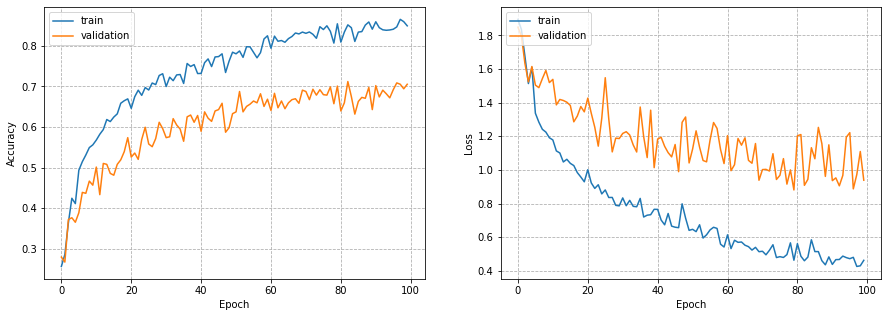

	Max validation accuracy: 71.2054 %
	Min validation loss: 0.88059

(2)


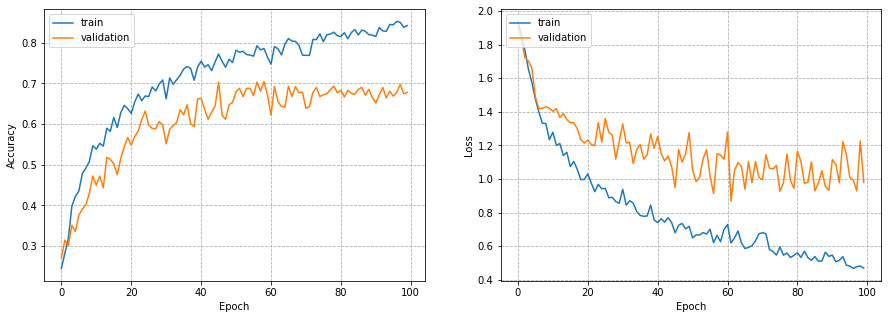

	Max validation accuracy: 70.4241 %
	Min validation loss: 0.86657

(3)


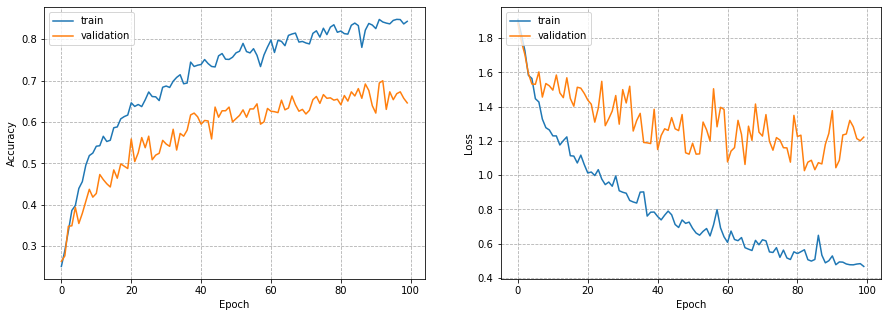

	Max validation accuracy: 69.9777 %
	Min validation loss: 1.02658


In [ ]:
show_results(history2)

In [ ]:
with open("history2", "wb") as fp:   
    pickle.dump(history2, fp)

### fold-3 <a name="fold-3"></a>

In [ ]:
FOLD_K = 3
REPEAT = 3

history3 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history3.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 8.6207%

Epoch 1/100
100%|██████████| 244/244 [00:05<00:00, 45.96it/s]



(1)


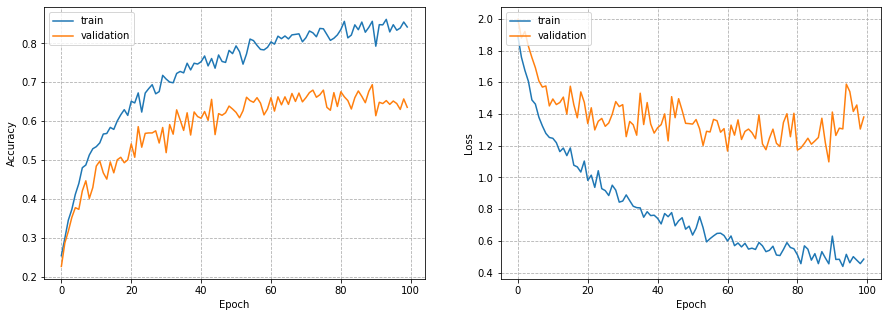

	Max validation accuracy: 69.3966 %
	Min validation loss: 1.09845

(2)


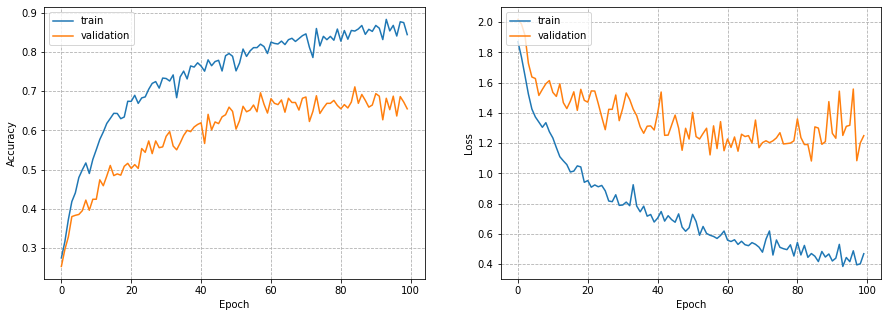

	Max validation accuracy: 71.1207 %
	Min validation loss: 1.08199

(3)


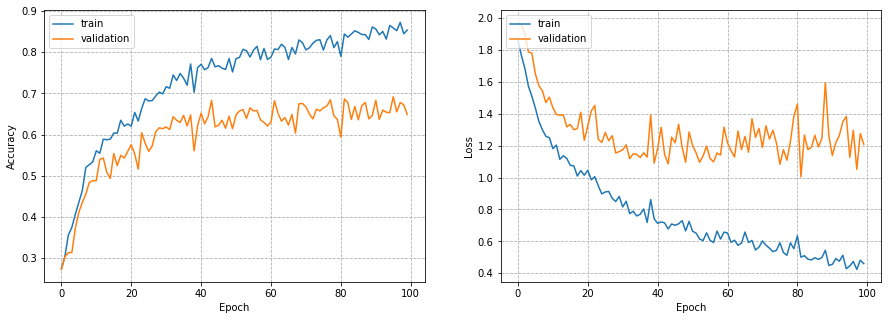

	Max validation accuracy: 69.1810 %
	Min validation loss: 1.00370


In [ ]:
show_results(history3)

In [ ]:
with open("history3", "wb") as fp:   
    pickle.dump(history3, fp)

### fold-4 <a name="fold-4"></a>

In [ ]:
FOLD_K = 4
REPEAT = 3

history4 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history4.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 8.9718%

Epoch 1/100
100%|██████████| 242/242 [00:05<00:00, 47.19it/s]
loss: 1.9083 - accuracy: 0.2570 - val_loss: 2.0063 - val_accuracy: 0.2440

Epoch 2/100
100%|██████████| 242/242 [00:05<00:00, 46.30it/s]
loss: 1.8108 - accuracy: 0.2948 - val_loss: 1.9317 - val_accuracy: 0.2671

Epoch 3/100
100%|██████████| 242/242 [00:05<00:00, 46.91it/s]
loss: 1.8221 - accuracy: 0.3218 - val_loss: 1.9751 - val_accuracy: 0.2460

Epoch 4/100
100%|██████████| 242/242 [00:05<00:00, 47.01it/s]
loss: 1.5786 - accuracy: 0.3869 - val_loss: 1.7665 - val_accuracy: 0.2913

Epoch 5/100
100%|██████████| 242/242 [00:05<00:00, 46.38it/s]
loss: 1.4570 - accuracy: 0.4604 - val_loss: 1.6437 - val_accuracy: 0.3286

Epoch 6/100
100%|██████████| 242/242 [00:05<00:00, 47.09it/s]
loss: 1.3981 - accuracy: 0.4691 - val_loss: 1.5674 - val_accuracy: 0.3609

Epoch 7/100
100%|██████████| 242/242 [00:05<00:00, 46.64it/


(1)


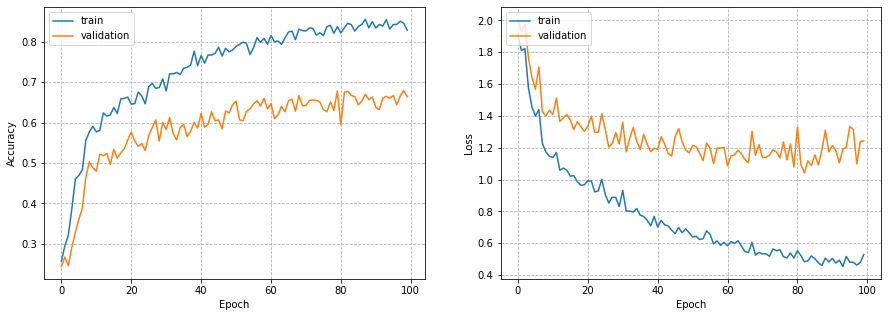

	Max validation accuracy: 67.9435 %
	Min validation loss: 1.04155

(2)


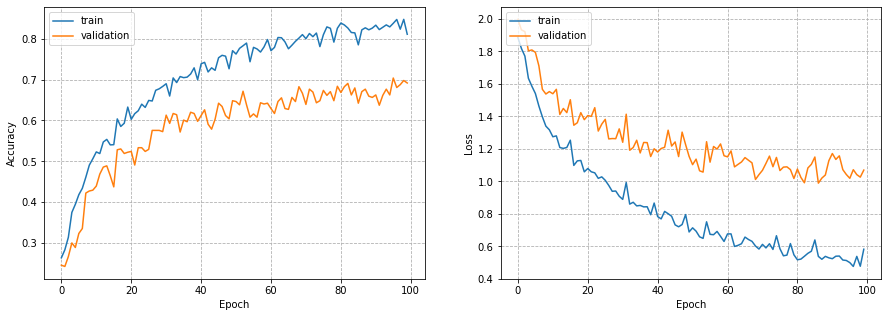

	Max validation accuracy: 70.3629 %
	Min validation loss: 0.98891

(3)


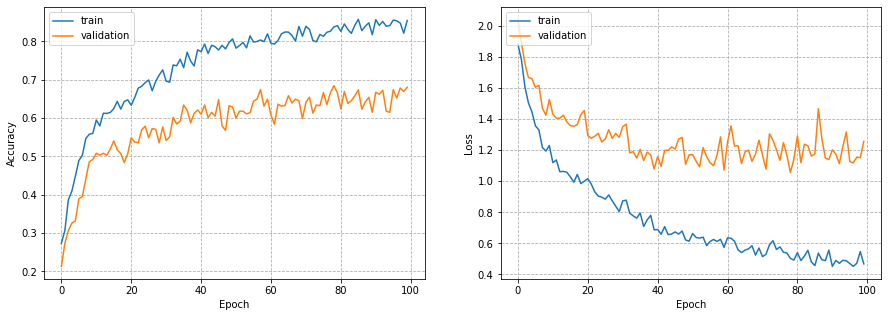

	Max validation accuracy: 68.4476 %
	Min validation loss: 1.05617


In [ ]:
show_results(history4)

In [ ]:
with open("history4", "wb") as fp:   
    pickle.dump(history4, fp)

### fold-5 <a name="fold-5"></a>

In [ ]:
FOLD_K = 5
REPEAT = 3

history5 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history5.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 12.5000%

Epoch 1/100
100%|██████████| 244/244 [00:05<00:00, 44.07it/s]
loss: 1.9586 - accuracy: 0.2524 - val_loss: 2.1162 - val_accuracy: 0.2125

Epoch 2/100
100%|██████████| 244/244 [00:05<00:00, 44.60it/s]
loss: 1.7783 - accuracy: 0.3099 - val_loss: 1.9298 - val_accuracy: 0.2917

Epoch 3/100
100%|██████████| 244/244 [00:05<00:00, 44.41it/s]
loss: 1.6571 - accuracy: 0.3636 - val_loss: 1.7462 - val_accuracy: 0.3427

Epoch 4/100
100%|██████████| 244/244 [00:05<00:00, 45.76it/s]
loss: 1.5585 - accuracy: 0.3965 - val_loss: 1.6430 - val_accuracy: 0.3667

Epoch 5/100
100%|██████████| 244/244 [00:05<00:00, 42.63it/s]
loss: 1.4882 - accuracy: 0.4266 - val_loss: 1.6184 - val_accuracy: 0.3677

Epoch 6/100
100%|██████████| 244/244 [00:05<00:00, 43.59it/s]
loss: 1.4247 - accuracy: 0.4696 - val_loss: 1.5846 - val_accuracy: 0.3802

Epoch 7/100
100%|██████████| 244/244 [00:05<00:00, 44.11it


(1)


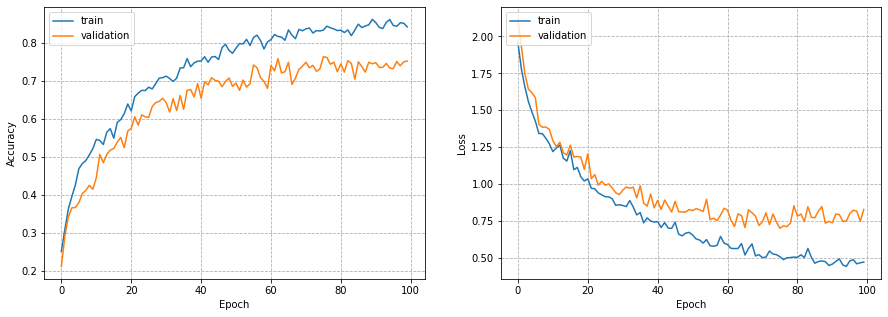

	Max validation accuracy: 76.4583 %
	Min validation loss: 0.69830

(2)


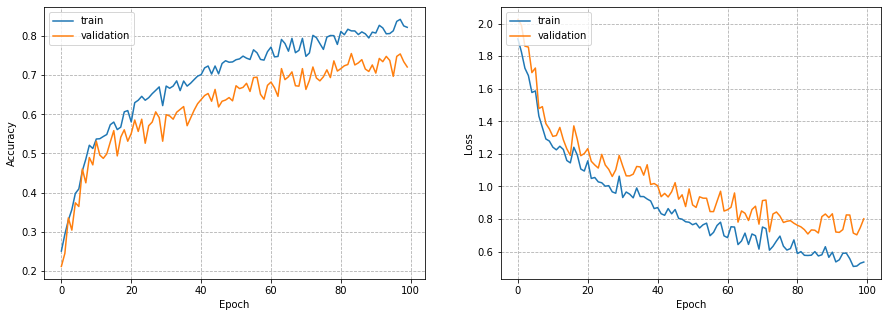

	Max validation accuracy: 75.5208 %
	Min validation loss: 0.70280

(3)


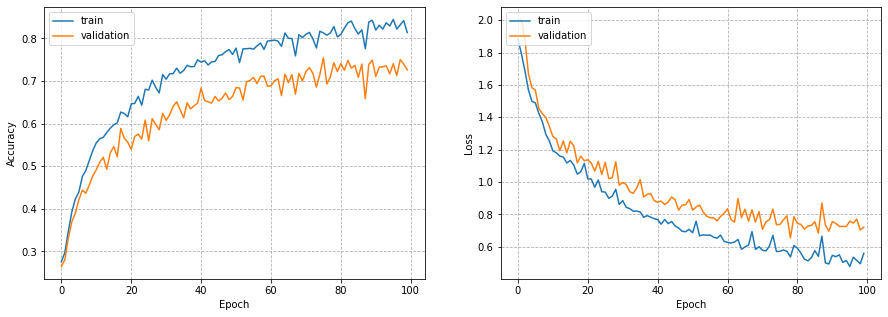

	Max validation accuracy: 75.4167 %
	Min validation loss: 0.65425


In [ ]:
show_results(history5)

In [ ]:
with open("history5", "wb") as fp:   
    pickle.dump(history5, fp)

### fold-6 <a name="fold-6"></a>

In [ ]:
FOLD_K = 6
REPEAT = 3

history6 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history6.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 12.9808%

Epoch 1/100
100%|██████████| 248/248 [00:06<00:00, 39.75it/s]
loss: 1.9331 - accuracy: 0.2433 - val_loss: 1.9421 - val_accuracy: 0.2151

Epoch 2/100
100%|██████████| 248/248 [00:06<00:00, 40.57it/s]
loss: 1.8628 - accuracy: 0.2819 - val_loss: 1.9095 - val_accuracy: 0.2632

Epoch 3/100
100%|██████████| 248/248 [00:06<00:00, 41.29it/s]
loss: 1.7603 - accuracy: 0.3191 - val_loss: 1.8068 - val_accuracy: 0.2825

Epoch 4/100
100%|██████████| 248/248 [00:06<00:00, 41.06it/s]
loss: 1.6113 - accuracy: 0.3749 - val_loss: 1.6942 - val_accuracy: 0.3269

Epoch 5/100
100%|██████████| 248/248 [00:06<00:00, 41.00it/s]
loss: 1.5276 - accuracy: 0.4123 - val_loss: 1.5688 - val_accuracy: 0.3918

Epoch 6/100
100%|██████████| 248/248 [00:05<00:00, 41.69it/s]
loss: 1.4170 - accuracy: 0.4477 - val_loss: 1.4488 - val_accuracy: 0.4219

Epoch 7/100
100%|██████████| 248/248 [00:05<00:00, 41.98it


(1)


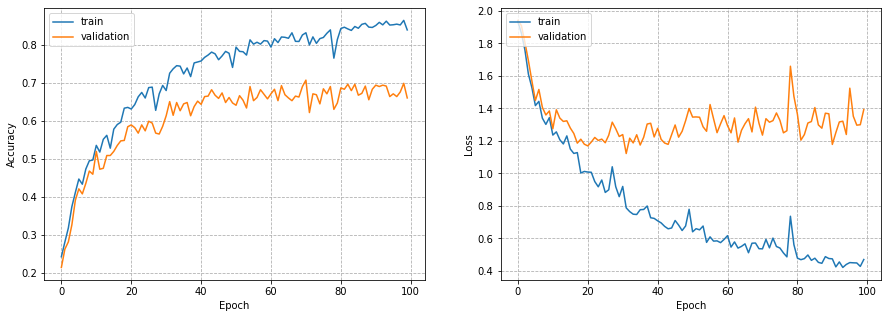

	Max validation accuracy: 70.7933 %
	Min validation loss: 1.12191

(2)


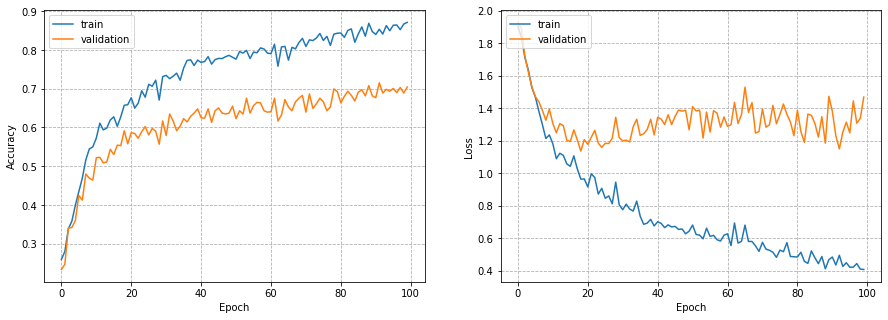

	Max validation accuracy: 71.5144 %
	Min validation loss: 1.13554

(3)


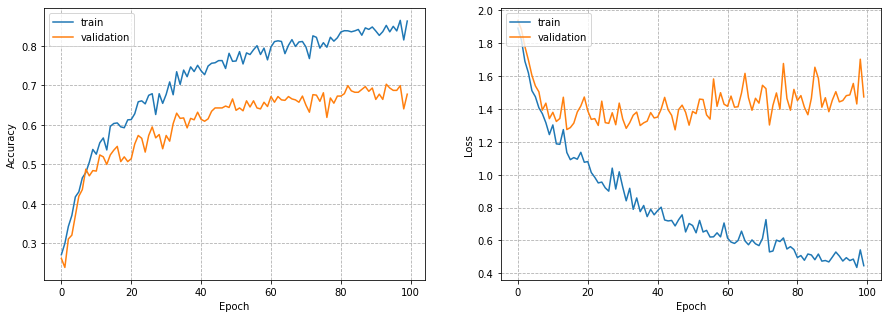

	Max validation accuracy: 70.3125 %
	Min validation loss: 1.27330


In [ ]:
show_results(history6)

In [ ]:
with open("history6", "wb") as fp:   
    pickle.dump(history6, fp)

### fold-7 <a name="fold-7"></a>

In [ ]:
FOLD_K = 7
REPEAT = 3

history7 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history7.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 12.3843%

Epoch 1/100
100%|██████████| 247/247 [00:06<00:00, 38.76it/s]
loss: 1.9173 - accuracy: 0.2716 - val_loss: 1.9992 - val_accuracy: 0.2373

Epoch 2/100
100%|██████████| 247/247 [00:06<00:00, 39.96it/s]
loss: 1.7835 - accuracy: 0.3047 - val_loss: 1.8476 - val_accuracy: 0.2558

Epoch 3/100
100%|██████████| 247/247 [00:06<00:00, 40.20it/s]
loss: 1.5605 - accuracy: 0.3902 - val_loss: 1.6658 - val_accuracy: 0.3553

Epoch 4/100
100%|██████████| 247/247 [00:06<00:00, 40.62it/s]
loss: 1.4616 - accuracy: 0.4480 - val_loss: 1.5433 - val_accuracy: 0.4340

Epoch 5/100
100%|██████████| 247/247 [00:06<00:00, 40.56it/s]
loss: 1.3664 - accuracy: 0.4932 - val_loss: 1.4900 - val_accuracy: 0.4086

Epoch 6/100
100%|██████████| 247/247 [00:05<00:00, 41.34it/s]
loss: 1.3663 - accuracy: 0.4923 - val_loss: 1.4320 - val_accuracy: 0.4363

Epoch 7/100
100%|██████████| 247/247 [00:05<00:00, 41.50it


(1)


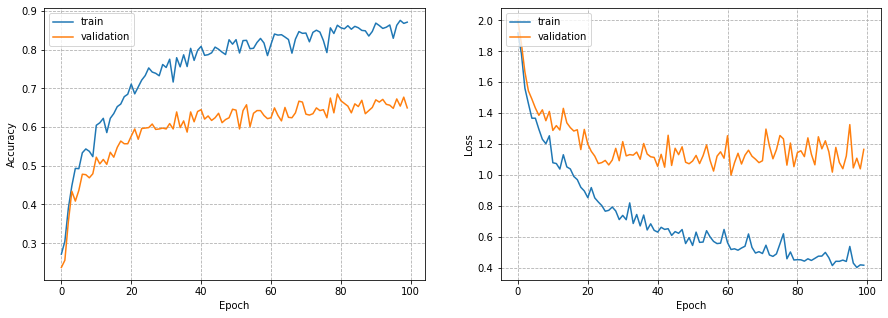

	Max validation accuracy: 68.5185 %
	Min validation loss: 0.99834

(2)


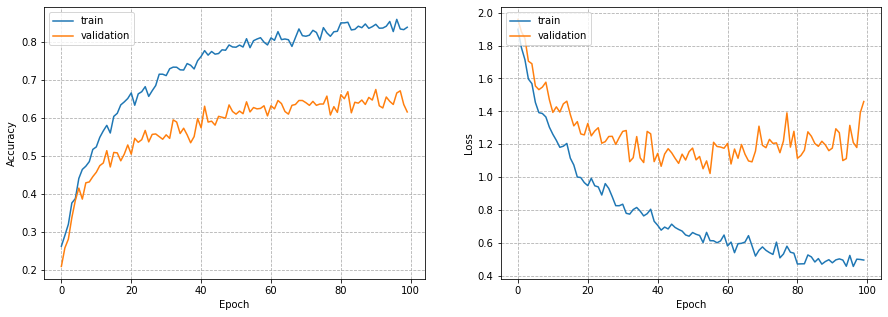

	Max validation accuracy: 67.4769 %
	Min validation loss: 1.02210

(3)


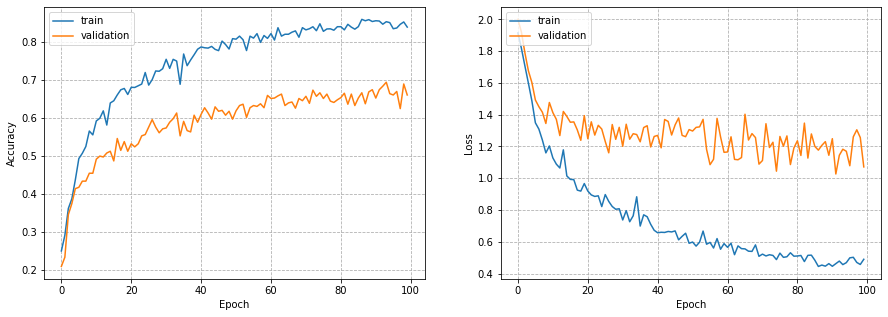

	Max validation accuracy: 69.3287 %
	Min validation loss: 1.02674


In [ ]:
show_results(history7)

In [ ]:
with open("history7", "wb") as fp:   
    pickle.dump(history7, fp)

### fold-8 <a name="fold-8"></a>

In [ ]:
FOLD_K = 8
REPEAT = 3

history8 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history8.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 12.8606%

Epoch 1/100
100%|██████████| 248/248 [00:06<00:00, 40.85it/s]
loss: 1.8631 - accuracy: 0.2781 - val_loss: 1.8136 - val_accuracy: 0.2752

Epoch 2/100
100%|██████████| 248/248 [00:05<00:00, 41.69it/s]
loss: 1.7352 - accuracy: 0.3414 - val_loss: 1.7121 - val_accuracy: 0.3353

Epoch 3/100
100%|██████████| 248/248 [00:05<00:00, 41.91it/s]
loss: 1.5870 - accuracy: 0.4003 - val_loss: 1.6584 - val_accuracy: 0.3678

Epoch 4/100
100%|██████████| 248/248 [00:05<00:00, 41.84it/s]
loss: 1.5461 - accuracy: 0.4171 - val_loss: 1.5830 - val_accuracy: 0.3882

Epoch 5/100
100%|██████████| 248/248 [00:05<00:00, 41.36it/s]
loss: 1.4750 - accuracy: 0.4386 - val_loss: 1.5915 - val_accuracy: 0.3834

Epoch 6/100
100%|██████████| 248/248 [00:05<00:00, 43.22it/s]
loss: 1.3979 - accuracy: 0.4681 - val_loss: 1.5523 - val_accuracy: 0.3942

Epoch 7/100
100%|██████████| 248/248 [00:06<00:00, 40.57it


(1)


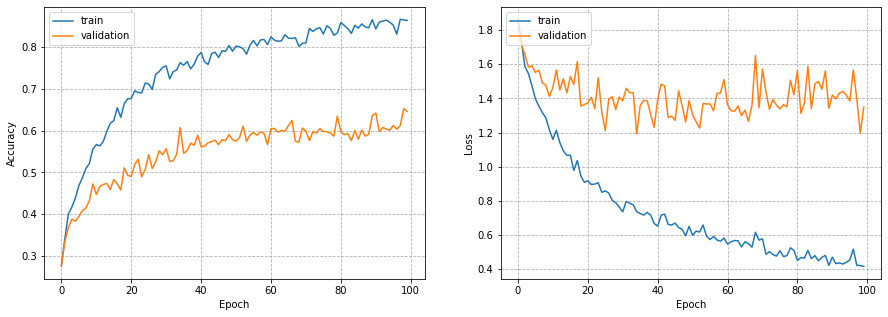

	Max validation accuracy: 65.2644 %
	Min validation loss: 1.19253

(2)


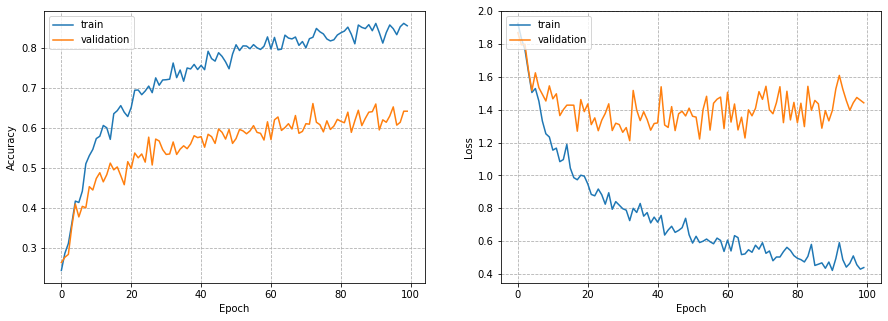

	Max validation accuracy: 66.2260 %
	Min validation loss: 1.21155

(3)


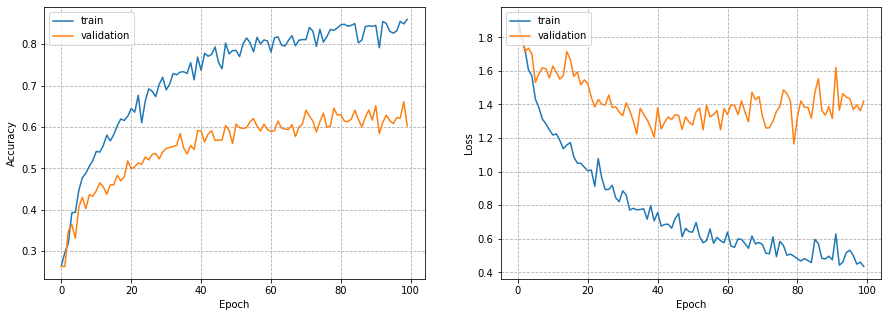

	Max validation accuracy: 66.1058 %
	Min validation loss: 1.16476


In [ ]:
show_results(history8)

In [ ]:
with open("history8", "wb") as fp:   
    pickle.dump(history8, fp)

### fold-9 <a name="fold-9"></a>

In [ ]:
FOLD_K = 9
REPEAT = 3

history9 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history9.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 10.6971%

Epoch 1/100
100%|██████████| 248/248 [00:05<00:00, 41.37it/s]
loss: 1.9055 - accuracy: 0.2625 - val_loss: 1.8226 - val_accuracy: 0.2548

Epoch 2/100
100%|██████████| 248/248 [00:05<00:00, 42.04it/s]
loss: 1.8542 - accuracy: 0.2815 - val_loss: 1.7706 - val_accuracy: 0.2825

Epoch 3/100
100%|██████████| 248/248 [00:05<00:00, 41.64it/s]
loss: 1.7238 - accuracy: 0.3343 - val_loss: 1.7050 - val_accuracy: 0.3089

Epoch 4/100
100%|██████████| 248/248 [00:06<00:00, 41.30it/s]
loss: 1.6369 - accuracy: 0.3638 - val_loss: 1.6716 - val_accuracy: 0.3401

Epoch 5/100
100%|██████████| 248/248 [00:05<00:00, 42.81it/s]
loss: 1.4707 - accuracy: 0.4307 - val_loss: 1.5698 - val_accuracy: 0.4219

Epoch 6/100
100%|██████████| 248/248 [00:06<00:00, 40.89it/s]
loss: 1.4016 - accuracy: 0.4652 - val_loss: 1.5626 - val_accuracy: 0.3930

Epoch 7/100
100%|██████████| 248/248 [00:05<00:00, 41.98it


(1)


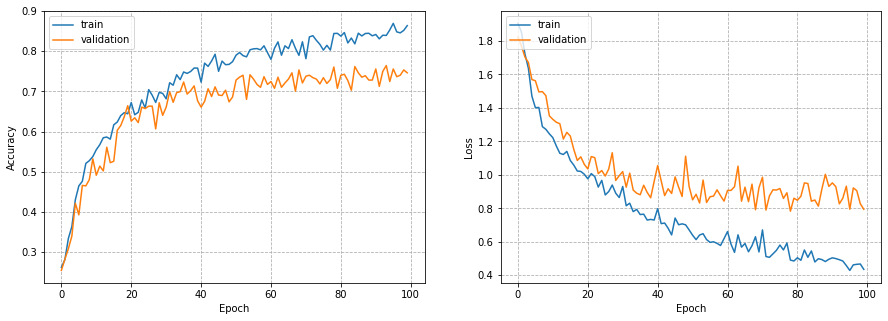

	Max validation accuracy: 76.4423 %
	Min validation loss: 0.78341

(2)


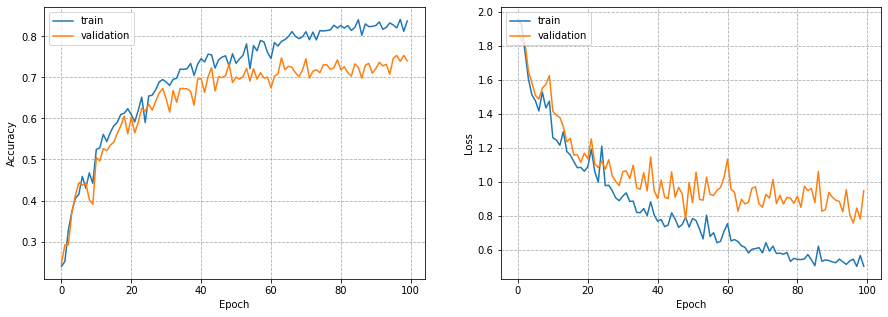

	Max validation accuracy: 75.3606 %
	Min validation loss: 0.75618

(3)


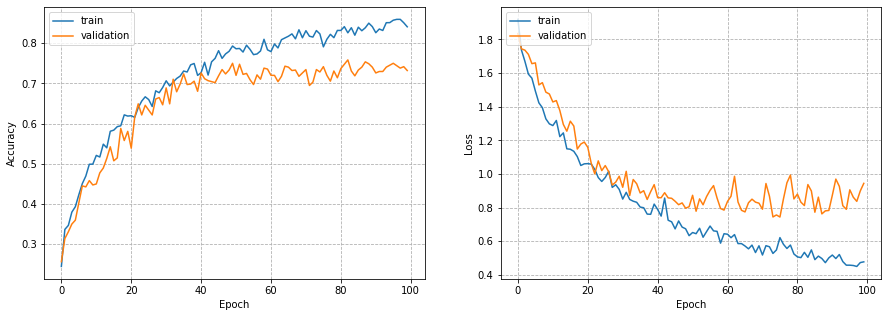

	Max validation accuracy: 75.8413 %
	Min validation loss: 0.74387


In [ ]:
show_results(history9)

In [ ]:
with open("history9", "wb") as fp:   
    pickle.dump(history9, fp)

### fold-10 <a name="fold-10"></a>

In [ ]:
FOLD_K = 10
REPEAT = 3

history10 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100, num_of_workers=4)
    history10.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 11.4583%

Epoch 1/100
100%|██████████| 247/247 [00:05<00:00, 41.47it/s]
loss: 1.9249 - accuracy: 0.2704 - val_loss: 1.8945 - val_accuracy: 0.2558

Epoch 2/100
100%|██████████| 247/247 [00:05<00:00, 41.96it/s]
loss: 1.8382 - accuracy: 0.2949 - val_loss: 1.7935 - val_accuracy: 0.2604

Epoch 3/100
100%|██████████| 247/247 [00:05<00:00, 41.84it/s]
loss: 1.7461 - accuracy: 0.3221 - val_loss: 1.7243 - val_accuracy: 0.3368

Epoch 4/100
100%|██████████| 247/247 [00:06<00:00, 41.08it/s]
loss: 1.5855 - accuracy: 0.3858 - val_loss: 1.5686 - val_accuracy: 0.3819

Epoch 5/100
100%|██████████| 247/247 [00:05<00:00, 41.73it/s]
loss: 1.5584 - accuracy: 0.3990 - val_loss: 1.5188 - val_accuracy: 0.3947

Epoch 6/100
100%|██████████| 247/247 [00:05<00:00, 41.86it/s]
loss: 1.4511 - accuracy: 0.4433 - val_loss: 1.4145 - val_accuracy: 0.4190

Epoch 7/100
100%|██████████| 247/247 [00:05<00:00, 41.73it


(1)


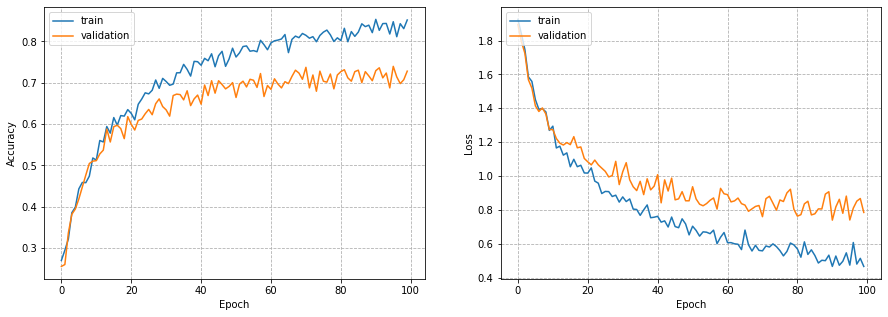

	Max validation accuracy: 73.9583 %
	Min validation loss: 0.73963

(2)


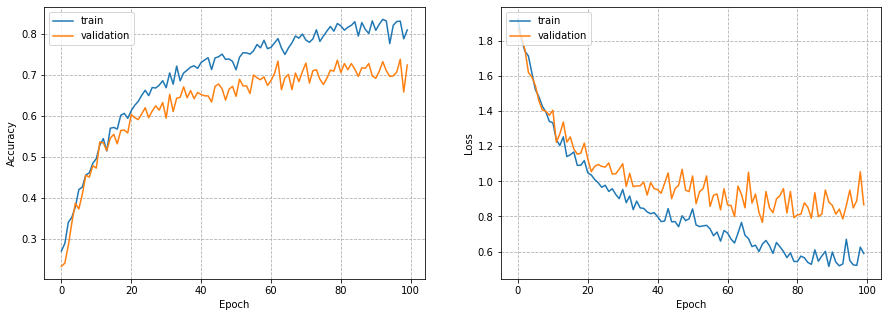

	Max validation accuracy: 73.8426 %
	Min validation loss: 0.76654

(3)


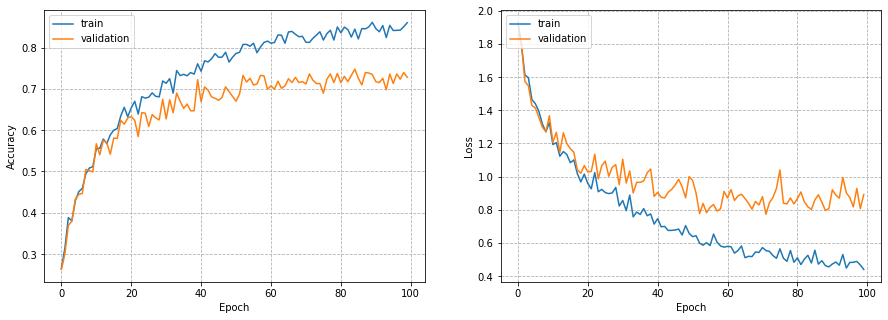

	Max validation accuracy: 74.7685 %
	Min validation loss: 0.77258


In [ ]:
show_results(history10)

In [ ]:
with open("history10", "wb") as fp:   
    pickle.dump(history10, fp)

---

## 6. Results  <a name="sixth-bullet"></a>

In [5]:
LOAD_HISTORY = True

if LOAD_HISTORY:
    with open("history1", "rb") as fp:   
        history1 = pickle.load(fp)

    with open("history2", "rb") as fp:   
        history2 = pickle.load(fp)

    with open("history3", "rb") as fp:   
        history3 = pickle.load(fp)

    with open("history4", "rb") as fp:   
        history4 = pickle.load(fp)

    with open("history5", "rb") as fp:   
        history5 = pickle.load(fp)

    with open("history6", "rb") as fp:   
        history6 = pickle.load(fp)

    with open("history7", "rb") as fp:   
        history7 = pickle.load(fp)

    with open("history8", "rb") as fp:   
        history8 = pickle.load(fp)

    with open("history9", "rb") as fp:   
        history9 = pickle.load(fp)

    with open("history10", "rb") as fp:   
        history10 = pickle.load(fp)

In [6]:
tot_history = [history1, history2, history3, history4, history5, history6, history7, history8, history9, history10]

---

### I) Results for **min loss**
a) calculate total min loss for 10-fold cross validation

In [8]:
avg_train_loss_per_fold = []
avg_val_loss_per_fold = []
std_train_loss_per_fold = []
std_val_loss_per_fold = []

tot_min_train_loss = 0.0
tot_min_val_loss = 0.0

# iterate over all folds
for fold_histories in tot_history:
    fold_min_train_losses = []
    fold_min_val_losses = []

    # collect min losses of all fold's histories
    for history in fold_histories:
        fold_min_train_losses.append(np.min(history['loss']))
        fold_min_val_losses.append(np.min(history['val_loss']))

    # avg min loss
    avg_train_loss_per_fold.append(np.mean(fold_min_train_losses))
    avg_val_loss_per_fold.append(np.mean(fold_min_val_losses))
    # std of min loss
    std_train_loss_per_fold.append(np.std(fold_min_train_losses))
    std_val_loss_per_fold.append(np.std(fold_min_val_losses))
    
    # add fold's avg min loss to sum of total loss 
    tot_min_train_loss += np.mean(fold_min_train_losses)
    tot_min_val_loss += np.mean(fold_min_val_losses)

avg_min_train_loss = tot_min_train_loss / len(tot_history)
avg_min_val_loss = tot_min_val_loss / len(tot_history)

print("10-Fold Cross Validation\n")
print("Average train min loss: %.4f" % avg_min_train_loss)
print("Average validation min loss: %.4f" % avg_min_val_loss)

10-Fold Cross Validation

Average train min loss: 0.4466
Average validation min loss: 0.9341


b) train and validation **min loss** for <ins>each fold</ins>

train set (folds): [0.4465391991261221, 0.45349274095157943, 0.416218377201935, 0.4606166660949875, 0.4754731016732305, 0.4212791176252468, 0.43419571025812354, 0.4246802176198652, 0.45979805402858287, 0.4740662980176176]
validation set (folds): [0.7384933744158063, 0.9245798701331728, 1.0613786982393814, 1.0288775249194073, 0.6851174036661783, 1.176916929391714, 1.0157296922471788, 1.1896168635441706, 0.76115231636243, 0.7595851804003303] 



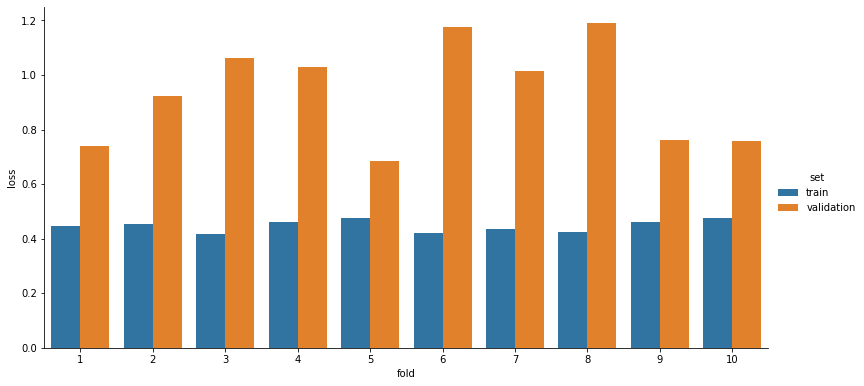

In [9]:
print("train set (folds):", avg_train_loss_per_fold)
print("validation set (folds):", avg_val_loss_per_fold, '\n')

df = pd.DataFrame(data=zip(list(range(1,11)), avg_train_loss_per_fold, avg_val_loss_per_fold), columns=['fold', 'train', 'validation'])
df = pd.melt(df, id_vars="fold", var_name="set", value_name="loss")

sns_plot = sns.catplot(x='fold', y='loss', hue='set', data=df, kind='bar', height=5.27, aspect=10.7/5.27)
sns_plot.savefig('CV_loss.png')

---

### II) Results for **max accuracy**
a) calculate total max accuracy for 10-fold cross validation


In [10]:
avg_train_acc_per_fold = []
avg_val_acc_per_fold = []
std_train_acc_per_fold = []
std_val_acc_per_fold = []

tot_max_train_acc = 0.0
tot_max_val_acc = 0.0

# iterate over all folds
for fold_histories in tot_history:
    fold_max_train_accs = []
    fold_max_val_accs = []

    # collect max accuracies of all fold's histories
    for history in fold_histories:
        fold_max_train_accs.append(np.max(history['accuracy']))
        fold_max_val_accs.append(np.max(history['val_accuracy']))
    
    # avg max accuracy
    avg_train_acc_per_fold.append(np.mean(fold_max_train_accs))
    avg_val_acc_per_fold.append(np.mean(fold_max_val_accs))
    # std of max accuracy
    std_train_acc_per_fold.append(np.std(fold_max_train_accs))
    std_val_acc_per_fold.append(np.std(fold_max_val_accs))
        
    # add fold's avg max accuracy to sum of total accuracy 
    tot_max_train_acc += np.mean(fold_max_train_accs)
    tot_max_val_acc += np.mean(fold_max_val_accs)
  
avg_max_train_acc = tot_max_train_acc / len(tot_history)
avg_max_val_acc = tot_max_val_acc / len(tot_history)

print("10-Fold Cross Validation\n")
print("Average train max accuracy: %.4f %%" % (avg_max_train_acc * 100))
print("Average validation max accuracy: %.4f %%" % (avg_max_val_acc * 100))

10-Fold Cross Validation

Average train max accuracy: 85.9177 %
Average validation max accuracy: 71.5626 %


b) train and validation **max accuracy** <ins>for each fold</ins>

train set (folds): [0.8595867208672088, 0.8552252710027101, 0.8723958333333334, 0.8535210055096418, 0.8499402322404371, 0.8671034946236559, 0.8644568151147097, 0.8627352150537635, 0.8568128360215054, 0.8499915654520919]
validation set (folds): [0.7522321428571428, 0.7053571428571428, 0.6989942528735632, 0.6891801075268816, 0.7579861111111111, 0.7087339743589743, 0.6844135802469137, 0.6586538461538461, 0.7588141025641026, 0.7418981481481483] 



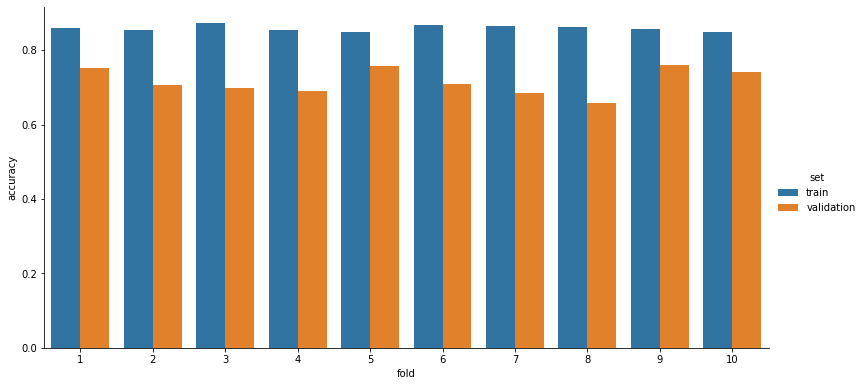

In [11]:
print("train set (folds):", avg_train_acc_per_fold)
print("validation set (folds):", avg_val_acc_per_fold, '\n')

df = pd.DataFrame(data=zip(list(range(1,11)), avg_train_acc_per_fold, avg_val_acc_per_fold), columns=['fold', 'train', 'validation'])
df = pd.melt(df, id_vars="fold", var_name="set", value_name="accuracy")

sns_plot = sns.catplot(x='fold', y='accuracy', hue='set', data=df, kind='bar', height=5.27, aspect=10.7/5.27)
sns_plot.savefig('CV_accuracy.png')

---

### III) Standard deviation (per fold)

a) loss

In [ ]:
print(std_train_loss_per_fold)
print(std_val_loss_per_fold)

[0.02521096645837428, 0.01955410863591633, 0.022684718921018136, 0.010955215349507798, 0.02824781178476253, 0.01157597826961263, 0.02380053454778898, 0.007845290291579161, 0.02970964857000941, 0.031167965502292436]
[0.011279708548712637, 0.07234959459337074, 0.04133752792414669, 0.028887471094013337, 0.021902776919597196, 0.06837804534730749, 0.012438365144152684, 0.019213121428424122, 0.01652349850448323, 0.014322567257947573]


b) accuracy

In [ ]:
print(std_train_acc_per_fold)
print(std_val_acc_per_fold)

[0.010283271840555922, 0.0074335434670096635, 0.008888807675983565, 0.00458656809744234, 0.00915486107169161, 0.003003706179230719, 0.007725097399481929, 0.002315106481774331, 0.01151226179232868, 0.010632717015100322]
[0.0032856253222945933, 0.005073728309890565, 0.008680349118961594, 0.010422084959187375, 0.004684283876122209, 0.004939434297250765, 0.0075798158581746105, 0.00427767558174334, 0.004425224766501267, 0.004119243152789871]
